## What is the Top Complaint Type?

Let's answer Question 1 of the problem statement:

Which type of complaint should the Department of Housing Preservation and Development of New York City focus on first?

#### Set up  and save files in Cloud Object Storage

In [5]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np

def __iter__(self): return 0

client_cred = ibm_boto3.client(service_name='Replace with your ibm service name',
    ibm_api_key_id='Replace with your ibm api id',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

bucket='Replace with your bucket id'


In [2]:
#Read Data
url= 'https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status'
nyc= pd.read_csv(url, parse_dates= True)

In [6]:
#Upload the file to cloud
nyc.to_csv('./df_raw.csv')
client_cred.upload_file('./df_raw.csv',bucket,'nyc.csv')

### Read data from the cloud storage

In [9]:
#Read file back
client_cred.download_file(Bucket=bucket,Key='nyc.csv',Filename='nyc')
df = pd.read_csv('nyc', parse_dates= ['created_date', 'closed_date'])

#View first rows of data
df.head()

,Unnamed: 0,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
0,0,2019-12-06 08:31:57,45100253,FLOORING/STAIRS,10027.0,236 WEST 122 STREET,WEST 122 STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.807542,-73.950956,NaT,RESIDENTIAL BUILDING,Open
1,1,2019-12-06 06:40:52,45100134,UNSANITARY CONDITION,10022.0,250 EAST 50 STREET,EAST 50 STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.755335,-73.969630,NaT,RESIDENTIAL BUILDING,Open
2,2,2019-12-06 04:01:22,45100112,PLUMBING,11226.0,1639 NOSTRAND AVENUE,NOSTRAND AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.646064,-73.949053,NaT,RESIDENTIAL BUILDING,Open
3,3,2019-12-06 04:35:22,45100011,PAINT/PLASTER,10467.0,3475 KNOX PLACE,KNOX PLACE,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.882535,-73.882801,NaT,RESIDENTIAL BUILDING,Open
4,4,2019-12-06 07:16:55,45099918,PAINT/PLASTER,10451.0,271 EAST 150 STREET,EAST 150 STREET,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.817890,-73.921811,NaT,RESIDENTIAL BUILDING,Open


#### Let's Load the data and perform some preprocessing techniques

In [10]:
#Check the shape of the data
print(df.shape)

#Check the data types of the data
print(df.dtypes)

(5949320, 16)
Unnamed: 0                         int64
created_date              datetime64[ns]
unique_key                         int64
complaint_type                    object
incident_zip                     float64
incident_address                  object
street_name                       object
address_type                      object
city                              object
resolution_description            object
borough                           object
latitude                         float64
longitude                        float64
closed_date               datetime64[ns]
location_type                     object
status                            object
dtype: object


### First, let's handle all the missing values

In [99]:
#Identify missing values 
missing = df.isnull()
missing.head()

#Count the missing values
for column in missing.columns.values.tolist():
    print(column)
    print (missing[column].value_counts())
    print('')

Unnamed: 0
False    5949320
Name: Unnamed: 0, dtype: int64

created_date
False    5949320
Name: created_date, dtype: int64

unique_key
False    5949320
Name: unique_key, dtype: int64

complaint_type
False    5949320
Name: complaint_type, dtype: int64

incident_zip
False    5868648
True       80672
Name: incident_zip, dtype: int64

incident_address
False    5896489
True       52831
Name: incident_address, dtype: int64

street_name
False    5896489
True       52831
Name: street_name, dtype: int64

address_type
False    5864547
True       84773
Name: address_type, dtype: int64

city
False    5869067
True       80253
Name: city, dtype: int64

resolution_description
False    5941517
True        7803
Name: resolution_description, dtype: int64

borough
False    5949320
Name: borough, dtype: int64

latitude
False    5868674
True       80646
Name: latitude, dtype: int64

longitude
False    5868674
True       80646
Name: longitude, dtype: int64

closed_date
False    5823406
True      125914
Name

###### Dealing with missing data
From the missing values count above, we can observe 10 columns with missing data.
 
- Replace by frequency
All columns with categorical data will be replaced except for 'resolution_description'.
- Replace by mean of column
All numeric columns will be replaced by the mean of the column except for 'closed_date".
- Replace by ''
'resolution_description' and 'closed_date' will be replaced by ''.

#### Create a class DataFrameImputer

In [100]:
#Create an object with a list of columns with missing values we would like to fill with the most frequent and mean values
cols=['unique_key', 'complaint_type', 'incident_zip',
       'incident_address', 'street_name', 'address_type', 'city',
     'borough', 'latitude', 'longitude',
        'location_type', 'status']

#Drop column 'Unnamed'
df= df.drop(['Unnamed: 0'], axis=1)

In [101]:
import numpy as np
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """Impute missing values.
        Columns of data type object are imputed with the most frequent  value in the column.
        Columns of other types are imputed with the mean of the column."""
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index= X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)
        

In [102]:
#Replace NaN with data
df[cols] = DataFrameImputer().fit_transform(df[cols])

In [103]:
df.isnull().sum()

created_date                   0
unique_key                     0
complaint_type                 0
incident_zip                   0
incident_address               0
street_name                    0
address_type                   0
city                           0
resolution_description      7803
borough                        0
latitude                       0
longitude                      0
closed_date               125914
location_type                  0
status                         0
dtype: int64

In [104]:
#replace nan by ''
df['resolution_description'].replace(np.nan, '', inplace = True)
print(df['resolution_description'].isnull().sum())

df['closed_date'].replace(np.nan, '', inplace = True)
print(df['closed_date'].isnull().sum())

0
0


### Filter the dataset and keep only the open requests data

In [105]:
#Work with data with open status
df_open= df[(df['status']== 'Open')]
df_open.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
0,2019-12-06 08:31:57,45100253,FLOORING/STAIRS,10027.0,236 WEST 122 STREET,WEST 122 STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.807542,-73.950956,,RESIDENTIAL BUILDING,Open
1,2019-12-06 06:40:52,45100134,UNSANITARY CONDITION,10022.0,250 EAST 50 STREET,EAST 50 STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.755335,-73.969630,,RESIDENTIAL BUILDING,Open
2,2019-12-06 04:01:22,45100112,PLUMBING,11226.0,1639 NOSTRAND AVENUE,NOSTRAND AVENUE,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.646064,-73.949053,,RESIDENTIAL BUILDING,Open
3,2019-12-06 04:35:22,45100011,PAINT/PLASTER,10467.0,3475 KNOX PLACE,KNOX PLACE,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.882535,-73.882801,,RESIDENTIAL BUILDING,Open
4,2019-12-06 07:16:55,45099918,PAINT/PLASTER,10451.0,271 EAST 150 STREET,EAST 150 STREET,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.817890,-73.921811,,RESIDENTIAL BUILDING,Open


In [106]:
df_open.shape
df_open.dtypes

created_date              datetime64[ns]
unique_key                         int64
complaint_type                    object
incident_zip                     float64
incident_address                  object
street_name                       object
address_type                      object
city                              object
resolution_description            object
borough                           object
latitude                         float64
longitude                        float64
closed_date                       object
location_type                     object
status                            object
dtype: object

In [107]:
# summary statistics of numeric columns in our dataframe 
df.describe(include='all')

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
count,5949320,5.949320e+06,5949320,5.949320e+06,5949320,5949320,5949320,5949320,5949320,5949320,5.949320e+06,5.949320e+06,5949320,5949320,5949320
unique,1605826,NaN,30,NaN,180776,6808,1,89,341,6,NaN,NaN,730425,5,5
top,2013-01-24 00:00:00,NaN,HEAT/HOT WATER,NaN,34 ARDEN STREET,GRAND CONCOURSE,ADDRESS,BROOKLYN,The Department of Housing Preservation and Dev...,BROOKLYN,NaN,NaN,,RESIDENTIAL BUILDING,Closed
freq,7581,NaN,1212034,NaN,67111,144075,5949320,2086187,1685764,1719240,NaN,NaN,125914,5942211,5816479
first,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2019-12-06 09:02:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.937499e+07,NaN,1.074737e+04,NaN,NaN,NaN,NaN,NaN,NaN,4.075414e+01,-7.391987e+01,NaN,NaN,NaN
std,NaN,7.766209e+06,NaN,5.095341e+02,NaN,NaN,NaN,NaN,NaN,NaN,9.025680e-02,5.647360e-02,NaN,NaN,NaN
min,NaN,1.562973e+07,NaN,1.000100e+04,NaN,NaN,NaN,NaN,NaN,NaN,4.049934e+01,-7.425312e+01,NaN,NaN,NaN
25%,NaN,2.284065e+07,NaN,1.045300e+04,NaN,NaN,NaN,NaN,NaN,NaN,4.067159e+01,-7.395165e+01,NaN,NaN,NaN


In [108]:
#Get the value counts of all types of complaints that are open
df_open['complaint_type'].value_counts().to_frame()

,complaint_type
GENERAL CONSTRUCTION,29623
PLUMBING,25924
PAINT - PLASTER,21647
NONCONST,15278
HEATING,11396
ELECTRIC,9224
HEAT/HOT WATER,4022
APPLIANCE,3720
UNSANITARY CONDITION,3596
PAINT/PLASTER,1673


###### Let's Visualize the distribution and frequencies of all open complaints received.

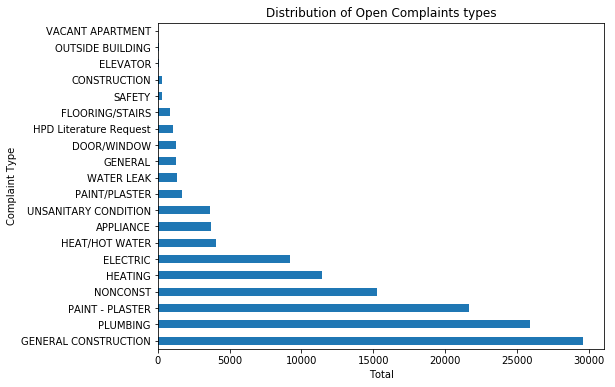

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt

#Visualize the distribution of open complaints types with bar plot

df_open['complaint_type'].value_counts().plot(kind='barh', figsize=(8,6))
plt.xlabel('Total')
plt.ylabel('Complaint Type')
plt.title('Distribution of Open Complaints types')
plt.show()


In [54]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and stopwords
from wordcloud import WordCloud, STOPWORDS

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.7 MB

The following NEW packages will be INSTALLED:

    wordcloud:       1.4.1-py36_0      conda-forge

The following packages will be UPDATED:

    ca-certificates: 2019.10.16-0                  --> 2019.11.28-hecc5488_0 conda-forge
    certifi:         2019.9.11-py36_

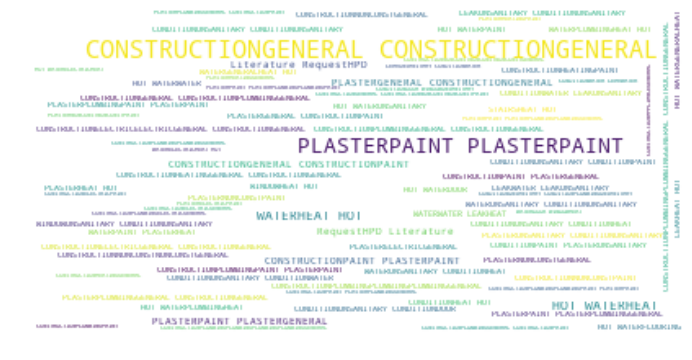

In [110]:
#Visualize with word cloud the most recurrent complaint

stopwords = set(STOPWORDS)
# instantiate a word cloud object
type_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
type_wc.generate(''.join(df_open['complaint_type']))

# display the word cloud
plt.figure(figsize= (12,6))
plt.imshow(type_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### Open and Closed Complaint type to address first considering complaints created till 31st Dec 2018

In [111]:
df_2018= df[(df['created_date'] <= '2018-12-31')]
df_2018['complaint_type'].value_counts().to_frame()

,complaint_type
HEAT/HOT WATER,1023062
HEATING,887869
PLUMBING,673260
GENERAL CONSTRUCTION,500863
UNSANITARY CONDITION,390705
PAINT - PLASTER,361257
PAINT/PLASTER,310888
ELECTRIC,289280
NONCONST,260890
DOOR/WINDOW,179467


### Top 5 complaint types received in New York City

In [112]:
df['complaint_type'].value_counts().to_frame().head()

,complaint_type
HEAT/HOT WATER,1212034
HEATING,887869
PLUMBING,707789
GENERAL CONSTRUCTION,500863
UNSANITARY CONDITION,446391


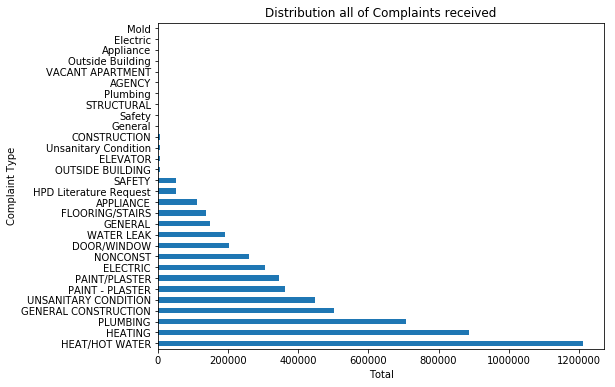

In [113]:
#Visualize the distribution of all complaints types with bar plot

df['complaint_type'].value_counts().plot(kind='barh', figsize=(8,6))
plt.xlabel('Total')
plt.ylabel('Complaint Type')
plt.title('Distribution of all Complaints received')
plt.show()

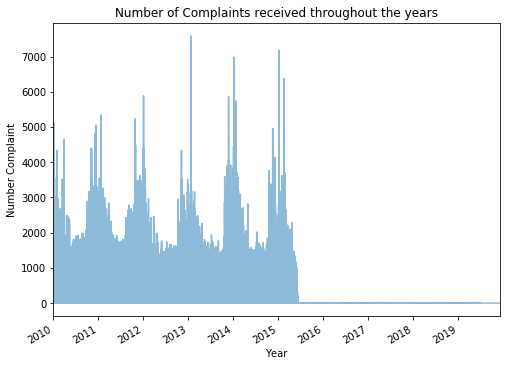

In [114]:
df['created_date'].value_counts().plot(alpha= 0.5, figsize=(8,6))
plt.xlabel('Year')
plt.ylabel('Number Complaint')
plt.title('Number of Complaints received throughout the years')
plt.show()

### Conclusion

From our exploratory analysis, we observe that GENERAL CONSTRUCTION complaints are the most recurrent for the complaints that are still open.
Therefore, if the Department of Housing Preservation and Development of New York City would like to focus on resolving all open complaints, they should look at focusing on GENERAL CONMSTRUCTION complaint as it is the complaint the most pertinant that is open. 

However, overall, the Department of Housing Preservation and Development of New York City should focus on resolving HEAT/HOT WATER complaints as we assess over 1,200,000 complaints received from 2010 to 2019. HEAT/HOT WATER also is one of the complaints that get solved quickly, therefore they consitute one of the most urgent complaint to handle.

Save the final dataframe 

In [115]:
df.to_csv('./data.csv')
client_cred.upload_file('./data.csv',
    Bucket=bucket, Key='data.csv')